<a href="https://colab.research.google.com/github/Smoulvad01/AI-C1-image-/blob/main/Inspecting_image_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='green'>IMPORT</font>

This file inspects the data BEFORE any pre-processing steps are made. Afterward, we import and pre-process the images, and inspect them AFTERWARDS, to ensure that the pre-processing worked as intended.

In [25]:
import cv2
from PIL import Image # To display images
from sklearn.decomposition import NMF, PCA
from collections import Counter

# TensorFlow and tf.keras
import tensorflow as tf
from keras.utils.vis_utils import plot_model

# Helper libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from importlib import reload
from collections import Counter
from PIL import Image
import os

reload(plt)
np.set_printoptions(suppress=True)
print(tf.__version__)

2.12.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
directory_train = "/content/drive/MyDrive/dataset_new/train"
directory_test = "/content/drive/MyDrive/dataset_new/test"

# <font color='green'>Inspect Data Before Processing </font>

### Check Image Sizes

In [24]:
# check for smallest and largest image 
from PIL import Image
import os

# Initialize variables to hold the smallest and largest images
smallest_image = None
largest_image = None

smallest_image_size = float('inf')  # set initial smallest size to infinity
largest_image_size = float('-inf')  # set initial largest size to negative infinity

# Iterate over all images in the specified directory
for filename in os.listdir(directory_train+"/Open/"):
    #if filename.endswith(".jpg") or filename.endswith(".png"):  # add more file types if needed
    img = Image.open(os.path.join(directory_train+"/Open/", filename))
    width, height = img.size
    image_size = width * height  # total pixel count
    #print("Debug: Image size: " + str(image_size))
    # Check if current image is the smallest one
    if image_size < smallest_image_size:
        smallest_image_size = image_size
        smallest_image = img

    # Check if current image is the largest one
    if image_size > largest_image_size:
        largest_image_size = image_size
        largest_image = img

print("Largest image size: " + str(largest_image_size))
print("Smallest image size: " + str(smallest_image_size))
# Now smallest_image and largest_image hold the smallest and largest images respectively.

Largest image size: 2293710
Smallest image size: 2250


### Statistics on Dataset Images 

In [ ]:
def image_sizes(directory):
    sizes = []
    for filename in os.listdir(directory):
        img = Image.open(os.path.join(directory, filename))
        width, height = img.size
        sizes.append(width * height)
    return sizes

# Calculate sizes
sizes_train_open = image_sizes(directory_train+"/Open/")
sizes_train_closed = image_sizes(directory_train+"/Closed/")
sizes_test_open = image_sizes(directory_test+"/Open/")
sizes_test_closed = image_sizes(directory_test+"/Closed/")

# Calculate statistics
def calculate_statistics(sizes):
    return {
        'mean': np.mean(sizes),
        'median': np.median(sizes),
        'min': np.min(sizes),
        'max': np.max(sizes),
        'std': np.std(sizes),
    }

# Print statistics
for name, sizes in [('Train/Open', sizes_train_open), 
                    ('Train/Closed', sizes_train_closed), 
                    ('Test/Open', sizes_test_open), 
                    ('Test/Closed', sizes_test_closed)]:
    stats = calculate_statistics(sizes)
    print(f"Image size statistics in {name}: ")
    for stat, value in stats.items():
        print(f"  {stat}: {value}")

### Visually Inspect Images 

# <font color='green'>Inspect Data After Processing</font>

### Load and Process Data using Keras

In [4]:
def load_image_dataset(directory):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        class_names=None,
        color_mode='grayscale',
        batch_size=32,
        image_size=(256, 256),
        shuffle=True,
        seed=42,
        validation_split=False,
        interpolation='mitchellcubic',
        follow_links=False,
        crop_to_aspect_ratio=False,
    )
    return dataset

In [20]:
#Define train_images and test_images
train_images = load_image_dataset(directory_train)
test_images = load_image_dataset(directory_test)

Found 1234 files belonging to 2 classes.
Found 218 files belonging to 2 classes.


In [9]:
#Labeling to give classnames 
class_names = train_images.class_names
print(class_names)

['Closed', 'Open']


In [21]:
#Checking the train test split ratio 
train_size = 1234
test_size = 218

print(test_size/(train_size+test_size))

0.15013774104683195


### Inspect Image Labels

In [10]:
# get the count of elements in the batched datasets
# For training data
train_class_counts = Counter()

for images, labels in train_images:
    train_class_counts.update(labels.numpy())

print("Training data class counts:", train_class_counts)

# For testing data
test_class_counts = Counter()

for images, labels in test_images:
    test_class_counts.update(labels.numpy())

print("Testing data class counts:", test_class_counts)

Training data class counts: Counter({1: 617, 0: 617})
Testing data class counts: Counter({1: 109, 0: 109})


### Visualize the Images

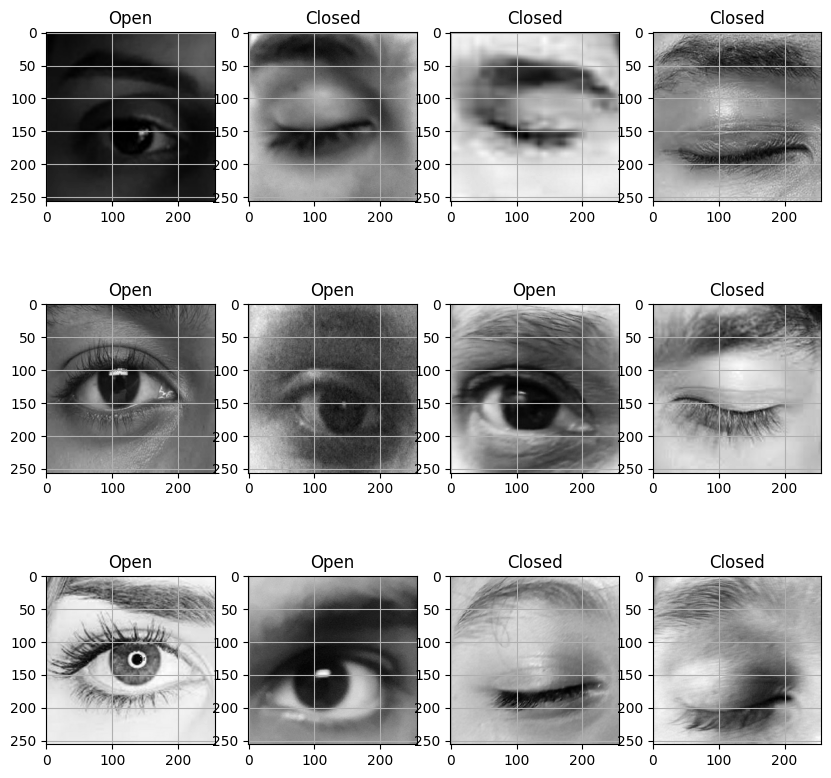

In [13]:
# plotting to inspect images visually and check correct labelling 
plt.figure(figsize=(10, 10))
for images, labels in train_images.take(1):
  for i in range(12):
    ax = plt.subplot(3,4 , i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.grid(True)

### Inspect Batches

In [18]:
# get the count of batches
batch_count = tf.data.experimental.cardinality(train_images).numpy()
print("Number of batches: " + str(batch_count))

Number of batches: 39


In [19]:
# inspect the batches
for images, labels in train_images.take(1):
    print(images.shape) #(1) denotes the number of images in the batch. (2) denotes the height and width of each image in pixels.(4) denotes the number of color channels in each image, which is typically RGB (red, green, blue) or grayscale.
    print(images.dtype)
    print(labels.shape)
    print(labels.dtype)

(32, 256, 256, 1)
<dtype: 'float32'>
(32,)
<dtype: 'int32'>


### Check For Corrupted Images

In [ ]:
def get_all_image_paths(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):  # Add/modify file extensions to suit your dataset
                image_paths.append(os.path.join(root, file))
    return image_paths

corrupted_images = []

# Obtain all image paths from training and testing directories
all_image_paths = get_all_image_paths(file_path_folder_train) + get_all_image_paths(file_path_folder_test)

for img_path in all_image_paths:
    try:
        img = Image.open(img_path)
        img.verify()  # This will raise an exception if the image is not valid
    except (IOError, SyntaxError) as e:
        corrupted_images.append(img_path)

print(f"Number of corrupted images: {len(corrupted_images)}")

Number of corrupted images: 0
